## Backend Text emotion detection model

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

In [9]:
df_test = pd.read_csv("test.csv", header=None)
df_train = pd.read_csv("train.csv", header=None)
df_val = pd.read_csv("val.csv", header=None)

In [18]:
df_train.head()

,0
0,i didnt feel humiliated;sadness
1,i can go from feeling so hopeless to so damned...
2,im grabbing a minute to post i feel greedy wro...
3,i am ever feeling nostalgic about the fireplac...
4,i am feeling grouchy;anger


In [20]:
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)

In [21]:
df_train.columns = ['0']
df_test.columns = ['0']
df_val.columns = ['0']

In [23]:
df_train[['statement','emotion']] = df_train['0'].str.split(';', expand=True)
df_test[['statement','emotion']] = df_test['0'].str.split(';', expand=True)
df_val[['statement','emotion']] = df_val['0'].str.split(';', expand=True)

In [25]:
df_train.head()

,0,statement,emotion
0,i didnt feel humiliated;sadness,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wro...,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy;anger,i am feeling grouchy,anger


In [26]:
df_train.drop('0', axis=1, inplace=True)
df_test.drop('0', axis=1, inplace=True)
df_val.drop('0', axis=1, inplace=True)

In [27]:
df_train['emotion'].value_counts()

,count
emotion,
joy,5362
sadness,4666
anger,2159
fear,1937
love,1304
surprise,572


<Axes: xlabel='count', ylabel='emotion'>

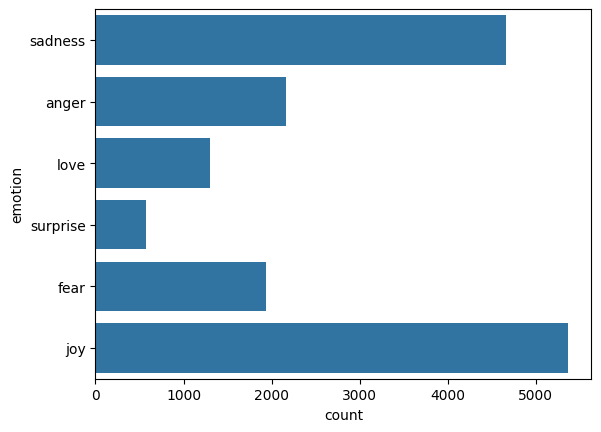

In [30]:
sns.countplot(df_train['emotion'])

# Data Preprocessing

In [32]:
!pip install neattext
import neattext.functions as nfx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 3.3 MB/s eta 0:00:00


In [33]:
df_train['statement'] = df_train['statement'].apply(nfx.remove_stopwords)
df_test['statement'] = df_test['statement'].apply(nfx.remove_stopwords)
df_val['statement'] = df_val['statement'].apply(nfx.remove_stopwords)

# Data Splitting

In [34]:
X_train = df_train['statement']
y_train = df_train['emotion']
X_test = df_test['statement']
y_test = df_test['emotion']
X_val = df_val['statement']
y_val = df_val['emotion']

# Model training

In [35]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [37]:
pipe_lr = Pipeline(steps=[('cv',CountVectorizer()),('lr',LogisticRegression())])
pipe_lr.fit(X_train,y_train)
pipe_lr.score(X_test,y_test)

0.886

In [38]:
pipe_lr = Pipeline(steps=[('cv',CountVectorizer()),('rf',RandomForestClassifier())])
pipe_lr.fit(X_train,y_train)
pipe_lr.score(X_test,y_test)

0.8835

In [39]:
pipe_lr = Pipeline(steps=[('cv', CountVectorizer()),('svm',SVC())])
pipe_lr.fit(X_train,y_train)
pipe_lr.score(X_test,y_test)

0.8495

In [40]:
#saving the model: Logistic regression seems best

import joblib
pipeline_file = open("text_emotion.pkl","wb")
joblib.dump(pipe_lr,pipeline_file)
pipeline_file.close()

# Frontend deployment using Streamlit

In [42]:
!pip install streamlit
import streamlit as st

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 67.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 97.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.5 MB/s eta 0:00:00


In [43]:
import altair as alt

In [45]:
pipe_lr = joblib.load(open("text_emotion.pkl", "rb"))

In [46]:
emotions_emoji_dict = {"anger": "😠", "fear": "😨😱", "joy": "😂", "sadness": "😔", "surprise": "😮", "love": "🤗"}

In [47]:
def predict_emotions(docx):
    results = pipe_lr.predict([docx])
    return results[0]

In [48]:
def get_prediction_proba(docx):
    results = pipe_lr.predict_proba([docx])
    return results

In [49]:
def main():
    st.title("Emotion Detection")
    st.subheader("Detect Emotions In user's Statement")

    with st.form(key='my_form'):
        raw_text = st.text_area("Type Here")
        submit_text = st.form_submit_button(label='Submit')

    if submit_text:
        col1, col2 = st.columns(2)

        prediction = predict_emotions(raw_text)
        probability = get_prediction_proba(raw_text)

        with col1:
            st.success("Original Text")
            st.write(raw_text)

            st.success("Prediction")
            emoji_icon = emotions_emoji_dict[prediction]
            st.write("{}:{}".format(prediction, emoji_icon))
            st.write("Confidence:{}".format(np.max(probability)))

        with col2:
            st.success("Prediction Probability")
            #st.write(probability)
            proba_df = pd.DataFrame(probability, columns=pipe_lr.classes_)
            #st.write(proba_df.T)
            proba_df_clean = proba_df.T.reset_index()
            proba_df_clean.columns = ["emotions", "probability"]

            fig = alt.Chart(proba_df_clean).mark_bar().encode(x='emotions', y='probability', color='emotions')
            st.altair_chart(fig, use_container_width=True)






if __name__ == '__main__':
    main()

2025-06-22 19:06:03.048 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-22 19:06:03.162 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-06-22 19:06:03.163 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-22 19:06:03.165 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-22 19:06:03.167 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-22 19:06:03.168 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-22 19:06:03.169 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-22 19:06:03.171 Thread 'MainThread': mi